In [1]:
#https://www.kaggle.com/code/vmarkin/advatt
# carregar as bibliotecas básicas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn.functional as F

# gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline

C:\Users\arthu\AppData\Local\Temp\ipykernel_15368\3035912685.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_data_path = 'dataset/X_train_sat6.csv'
train_label_path = 'dataset/y_train_sat6.csv'
test_data_path = 'dataset/X_test_sat6.csv'
test_label_path = 'dataset/y_test_sat6.csv'
train_qtdy = 100000
test_qtdy = 50000     

In [3]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows, dtype=np.uint8)
    data=data.values ## converting the data into numpy array
    return data

In [4]:
train_data=data_read(train_data_path, nrows=train_qtdy)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=train_qtdy)
print("Train data label shape:" + str(train_data_label.shape))
print()

##Read test data
test_data=data_read(test_data_path, nrows=test_qtdy)
print("Test data shape:" + str(test_data.shape))


##Read test data labels
test_data_label=data_read(test_label_path,nrows=test_qtdy)
print("Test data label shape:" + str(test_data_label.shape))

Train data shape:(100000, 3136)
Train data label shape:(100000, 6)

Test data shape:(50000, 3136)
Test data label shape:(50000, 6)


In [5]:
example = train_data[0]
print(example.shape)
reshaped_ex = example.reshape((28,28,4))[:,:,:3] #convert to rgb 
print(reshaped_ex.shape)

(3136,)
(28, 28, 3)


In [6]:
from matplotlib import pyplot as plt 

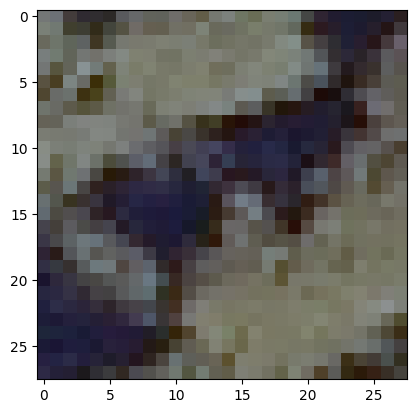

In [7]:
plt.imshow(reshaped_ex)

In [8]:
ex_label = train_data_label[0]
ex_label

array([0, 0, 1, 0, 0, 0], dtype=uint8)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from sklearn.metrics import accuracy_score

torch.manual_seed(4)

In [10]:
class SatImgDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = T.ToTensor()
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.transform(self.X[index])
        y = torch.FloatTensor(self.y[index])
        return {'x':x, 'y':y}

In [11]:
train_data_reshaped = train_data.reshape(train_qtdy,28,28,4)
test_data_reshaped = test_data.reshape(test_qtdy,28,28,4) 

In [12]:
dataset_test = SatImgDataset(test_data_reshaped, test_data_label)
dataset_train = SatImgDataset(train_data_reshaped, train_data_label)

loader_train = DataLoader(dataset_train, 512, shuffle=True)
loader_test = DataLoader(dataset_test, 512, shuffle=False)

In [13]:
# device = torch.device('cpu')
# model = nn.Sequential(
#     nn.Conv2d(4, 32, (3,3)),
#     nn.ReLU(),
#     nn.MaxPool2d((2,2)),
#     nn.Conv2d(32, 64, (3,3)),
#     nn.ReLU(),
#     nn.MaxPool2d((2,2)),
#     nn.Flatten(),
#     nn.Linear(1600,512),
#     nn.ReLU(),
#     nn.Linear(512, 6),
#     nn.Softmax()
# ).to(device)

In [14]:
# from brevitas.nn import QuantConv2d, QuantReLU, QuantLinear
# num_classes = 6
# device = torch.device('cpu')
# model = nn.Sequential(
#     QuantConv2d(4,32,(3,3),bias=False),
#     nn.ReLU(),
#     nn.MaxPool2d((2,2)),
#     QuantConv2d(32,64,(3,3),bias=False),
#     nn.ReLU(),
#     nn.MaxPool2d((2,2)),
#     nn.Flatten(),
#     QuantLinear(1600,512,bias=False),
#     nn.ReLU(),
#     QuantLinear(512,num_classes,bias=False),
#     nn.Softmax()
# ).to(device)

In [15]:
num_classes = 6
#rede treinada com 8 bits de peso
from brevitas.nn import QuantConv2d, QuantLinear, QuantIdentity

device = torch.device('cpu')
model = nn.Sequential(
    QuantIdentity(bit_width=8),
    QuantConv2d(4,32,(3,3), weight_bit_width=8 , bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    QuantConv2d(32,64,(3,3), weight_bit_width=8, bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    QuantLinear(1600,512, weight_bit_width=8 , bias=True),
    nn.ReLU(),
    QuantLinear(512,num_classes, weight_bit_width=8 , bias=True),
    nn.Softmax(dim=1)
).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
criterion = nn.BCELoss()
model.train()
for e in range(epochs):
    for batch in tqdm(loader_train):
        pred = model(batch['x'].to(device))
        loss = criterion( pred, batch['y'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/196 [00:00<?, ?it/s]C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\torch\_tensor.py:1394: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ..\c10/core/TensorImpl.h:1911.)
  return super().rename(names)
100%|██████████| 196/196 [00:40<00:00,  4.85it/s]


In [17]:
def fast_gradient_sign_method(model, imgs, labels, attack_params):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    pred_logprob = torch.log(preds)
    #print(labels.dtype)
    # Calculate loss by NLL
    loss = nn.BCELoss()(preds, labels.to(device))
    loss.backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + attack_params['epsilon'] * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [18]:
def eval_model(model, dataloader, fake_generator=None, attack_params=None):
    y_pred = []
    y_true = []
    
    for i, batch in enumerate(dataloader):
        if fake_generator is not None:
            fake_imgs, _ = fake_generator(model, batch['x'],batch['y'], attack_params)
            with torch.no_grad():
                pred = model(fake_imgs.to(device))
        else:
            with torch.no_grad():
                pred = model(batch['x'].to(device))
        y_pred.append(pred.argmax(dim=1).cpu().numpy())
        y_true.append(batch['y'].argmax(dim=1).numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return accuracy_score(y_true, y_pred)

In [19]:
eps = np.logspace(-2, 0, 10)
acc_attack = [eval_model(model, loader_test, fast_gradient_sign_method, {'epsilon': e}) for e in eps]

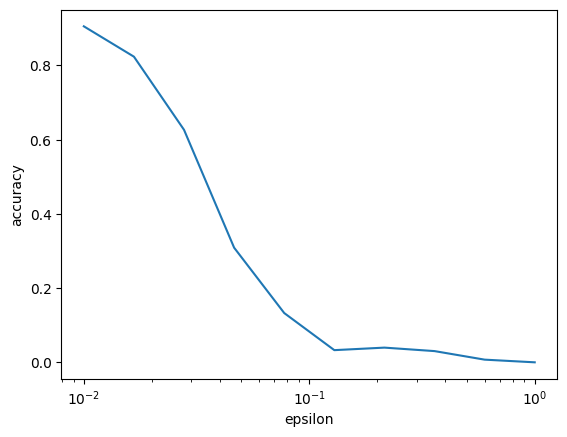

In [20]:
plt.figure()
plt.plot(eps, acc_attack)
plt.xscale('log')
plt.ylabel("accuracy")
plt.xlabel('epsilon')
plt.show()

In [21]:
def predict_one_image(img_data, y):
    with torch.no_grad():
        pred = model(T.ToTensor()(img_data).unsqueeze(0).to(device))
    true_label = y.argmax()
    pred_label = pred[0].argmax()
    print(pred)
    plt.imshow(img_data)
    print("True class: {}, predicted class: {}".format(true_label, pred_label))

In [22]:
attack_params = {'epsilon':0.02}

img_data = test_data[221].reshape((28,28,4))
labels = torch.FloatTensor(test_data_label[221]).unsqueeze(0)

f_img, noise_grad = fast_gradient_sign_method(model, T.ToTensor()(img_data).unsqueeze(0), labels, attack_params)
fake_img = f_img.squeeze().numpy().transpose(1,2,0)

tensor([[5.8436e-07, 1.0150e-06, 9.9999e-01, 1.1423e-05, 7.7709e-08, 6.8742e-12]])
True class: 2, predicted class: 2


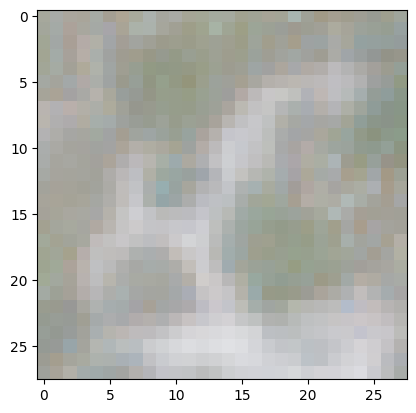

In [23]:
predict_one_image(img_data, labels)

In [24]:
with torch.no_grad():
    correct = 0
    for batch in loader_test:
        pred = model(batch['x'].to(device))
        predicted = torch.max(pred, 1)[1]
        real_class = torch.max(batch['y'].to(device), 1)[1]
        correct += (predicted == real_class).sum()

print(f"certos: {correct.item()}!!!")
print(f"precisão: {correct.item()/len(dataset_test)*100}%!!!")


certos: 48930!!!
precisão: 97.86%!!!
